## Task 2: Develop Time Series Forecasting Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
# Load the preprocessed data
df_TSLA = pd.read_csv('../data/processed/TSLA_processed.csv')
df_BND = pd.read_csv('../data/processed/BND_processed.csv')
df_SPY = pd.read_csv('../data/processed/SPY_processed.csv')

In [4]:
df_TSLA.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,MA20,MA50,MA200,Volatility
0,14.858000,14.883333,14.217333,14.620667,71466000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,14.303333,14.433333,13.810667,14.006000,80527500,0.0,0.0,-0.042041,NaN,NaN,NaN,NaN
2,14.004000,14.280000,13.614000,14.085333,93928500,0.0,0.0,0.005664,NaN,NaN,NaN,NaN
3,14.223333,14.318667,13.985333,14.063333,44526000,0.0,0.0,-0.001562,NaN,NaN,NaN,NaN
4,14.187333,14.253333,14.000667,14.041333,51637500,0.0,0.0,-0.001564,NaN,NaN,NaN,NaN


In [5]:
df_BND.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Daily_Return,MA20,MA50,MA200,Volatility
0,63.190117,63.389433,63.182450,63.358768,2218800,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,63.427742,63.565729,63.397078,63.542732,5820100,0.0,0.0,0.0,0.002904,NaN,NaN,NaN,NaN
2,63.650095,63.918401,63.650095,63.726753,3887600,0.0,0.0,0.0,0.002896,NaN,NaN,NaN,NaN
3,63.734381,63.841703,63.665390,63.765045,2433400,0.0,0.0,0.0,0.000601,NaN,NaN,NaN,NaN
4,63.711353,63.711353,63.604031,63.665359,1873400,0.0,0.0,0.0,-0.001563,NaN,NaN,NaN,NaN


In [6]:
df_SPY.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Daily_Return,MA20,MA50,MA200,Volatility
0,173.974595,174.396086,172.120025,173.173752,121465900,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,172.111598,172.280192,169.734396,170.046295,169632600,0.0,0.0,0.0,-0.018060,NaN,NaN,NaN,NaN
2,170.358170,170.889252,167.635342,168.444611,209151400,0.0,0.0,0.0,-0.009419,NaN,NaN,NaN,NaN
3,169.793432,170.889312,169.338228,170.543686,125346700,0.0,0.0,0.0,0.012462,NaN,NaN,NaN,NaN
4,171.976757,173.789176,171.959906,173.569992,147217800,0.0,0.0,0.0,0.017745,NaN,NaN,NaN,NaN


In [7]:
# Split the data into training and testing sets
train_size = int(len(df_TSLA) * 0.8)
df_TSLA_train = df_TSLA.iloc[:train_size]
df_TSLA_test = df_TSLA.iloc[train_size:]

### ARIMA MODEL 

In [8]:
# ARIMA Model
print("Developing ARIMA Model for TSLA")
arima_model = ARIMA(df_TSLA_train['Close'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
#arima_forecast = arima_model_fit.forecast(steps=len(df_TSLA_test))[0]
arima_forecast = arima_model_fit.forecast(steps=len(df_TSLA_test))


Developing ARIMA Model for TSLA


In [9]:
arima_mae = mean_absolute_error(df_TSLA_test['Close'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(df_TSLA_test['Close'], arima_forecast))
arima_mape = mean_absolute_percentage_error(df_TSLA_test['Close'], arima_forecast)

In [10]:
print(f"ARIMA Model Performance:")
print(f"MAE: {arima_mae:.2f}")
print(f"RMSE: {arima_rmse:.2f}")
print(f"MAPE: {arima_mape:.2f}%")

ARIMA Model Performance:
MAE: 39.20
RMSE: 49.76
MAPE: 0.18%


### SARIMA Model

In [11]:
# SARIMA Model
print("Developing SARIMA Model for TSLA")
sarima_model = SARIMAX(df_TSLA_train['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()
#sarima_forecast = sarima_model_fit.forecast(steps=len(df_TSLA_test))[0]
sarima_forecast = sarima_model_fit.forecast(steps=len(df_TSLA_test))

sarima_mae = mean_absolute_error(df_TSLA_test['Close'], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(df_TSLA_test['Close'], sarima_forecast))
sarima_mape = mean_absolute_percentage_error(df_TSLA_test['Close'], sarima_forecast)

print(f"SARIMA Model Performance:")
print(f"MAE: {sarima_mae:.2f}")
print(f"RMSE: {sarima_rmse:.2f}")
print(f"MAPE: {sarima_mape:.2f}%")

Developing SARIMA Model for TSLA
SARIMA Model Performance:
MAE: 32.50
RMSE: 40.29
MAPE: 0.15%


In [20]:
# confidence intervals to assess forecast reliability.
sarima_model_fit.get_forecast(steps=len(df_TSLA_test)).conf_int()

,lower Close,upper Close
1986,170.527828,192.069299
1987,165.371256,195.988838
1988,161.366895,198.812665
1989,158.486359,201.786719
1990,154.931445,203.307887
...,...,...
2478,-82.875681,514.552339
2479,-83.696381,514.553258
2480,-84.321709,514.748239
2481,-84.518142,515.371164


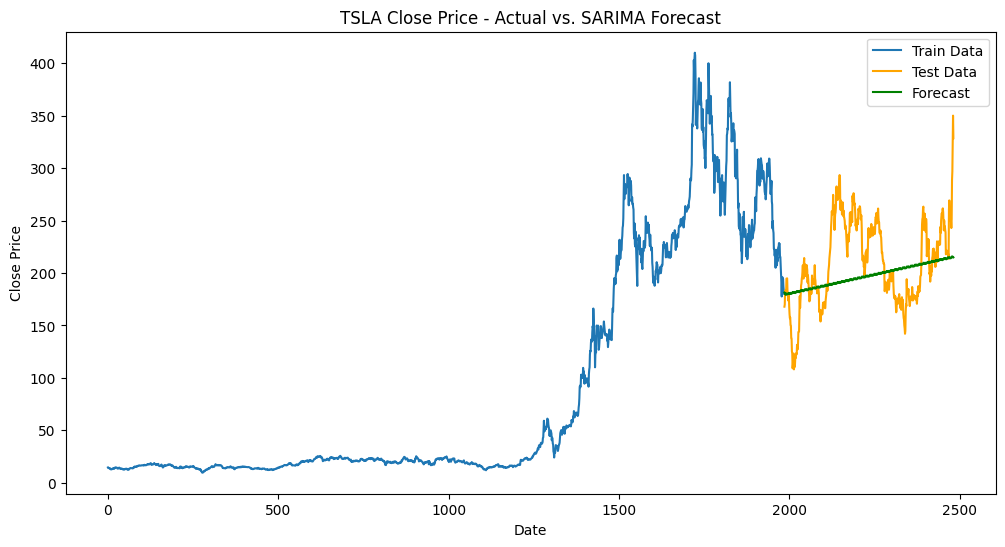

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df_TSLA_train['Close'], label='Train Data')
plt.plot(df_TSLA_test['Close'], label='Test Data', color='orange')
plt.plot(df_TSLA_test.index, sarima_forecast, label='Forecast', color='green')
plt.title("TSLA Close Price - Actual vs. SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


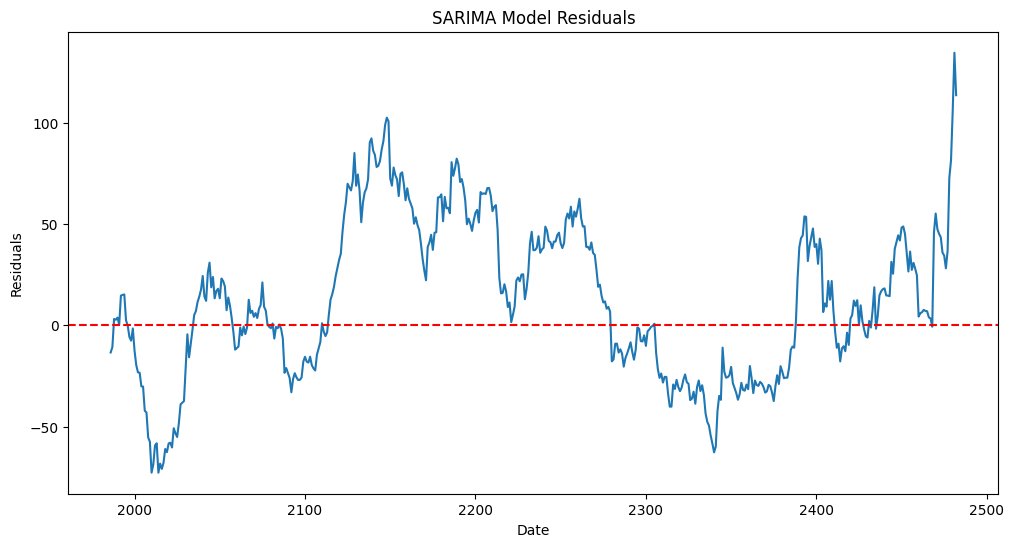

In [22]:
residuals = df_TSLA_test['Close'] - sarima_forecast
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("SARIMA Model Residuals")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

### LSTM Model

In [14]:
# LSTM Model
print("Developing LSTM Model for TSLA")
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, 1), return_sequences=False))  # Change input_shape to (1, 1)
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Reshape X_train to (len(df_TSLA_train), 1, 1)
X_train = df_TSLA_train[['Close']].values.reshape((len(df_TSLA_train), 1, 1))
y_train = df_TSLA_train['Close'].values

# Train the model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Reshape X_test to (len(df_TSLA_test), 1, 1)
X_test = df_TSLA_test[['Close']].values.reshape((len(df_TSLA_test), 1, 1))
lstm_forecast = lstm_model.predict(X_test)

# Evaluate the model
lstm_mae = mean_absolute_error(df_TSLA_test['Close'], lstm_forecast.flatten())
lstm_rmse = np.sqrt(mean_squared_error(df_TSLA_test['Close'], lstm_forecast.flatten()))
lstm_mape = mean_absolute_percentage_error(df_TSLA_test['Close'], lstm_forecast.flatten())

print(f"LSTM Model Performance:")
print(f"MAE: {lstm_mae:.2f}")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAPE: {lstm_mape:.2f}%")


Developing LSTM Model for TSLA
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
LSTM Model Performance:
MAE: 96.14
RMSE: 104.02
MAPE: 0.44%


### Model Performance Comparison 

In [16]:
# Compare Model Performance
print("Comparing Model Performance:")
print(f"ARIMA MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%")
print(f"SARIMA MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%")
print(f"LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.2f}%")

Comparing Model Performance:
ARIMA MAE: 39.20, RMSE: 49.76, MAPE: 0.18%
SARIMA MAE: 32.50, RMSE: 40.29, MAPE: 0.15%
LSTM MAE: 96.14, RMSE: 104.02, MAPE: 0.44%


In [17]:
# Select the best model based on performance metrics
if arima_mape < sarima_mape and arima_mape < lstm_mape:
    best_model = "ARIMA"
    best_forecast = arima_forecast
elif sarima_mape < arima_mape and sarima_mape < lstm_mape:
    best_model = "SARIMA"
    best_forecast = sarima_forecast
else:
    best_model = "LSTM"
    best_forecast = lstm_forecast.flatten()

print(f"The best model is {best_model} based on MAPE.")

The best model is SARIMA based on MAPE.


The best model is SARIMA based on MAPE.


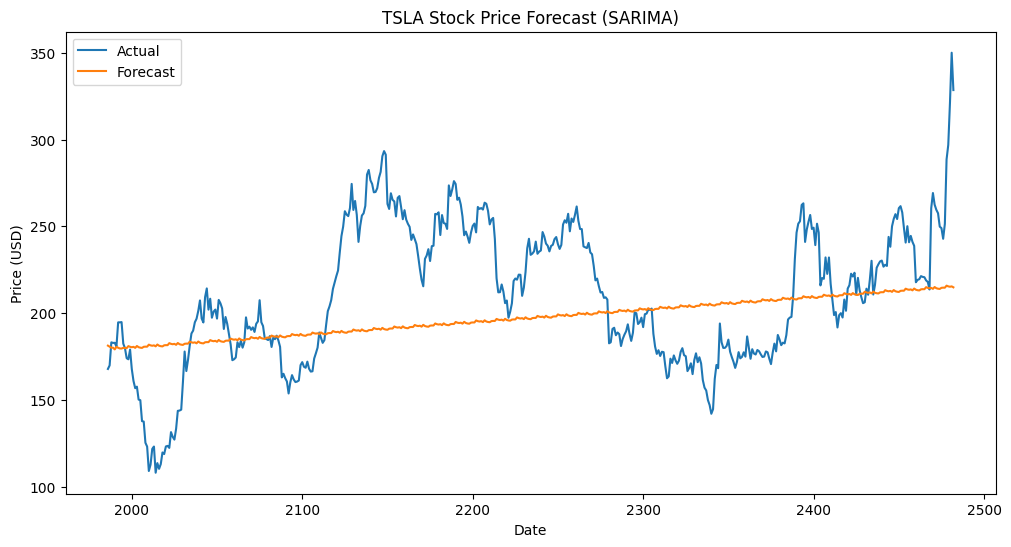

In [18]:
print(f"The best model is {best_model} based on MAPE.")

# Visualize the forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_TSLA_test.index, df_TSLA_test['Close'], label='Actual')
plt.plot(df_TSLA_test.index, best_forecast, label='Forecast')
plt.title(f"TSLA Stock Price Forecast ({best_model})")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()